In [8]:
import os
import sys
import random
from glob import glob
from copy import deepcopy
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

# enable use of local modules
repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

from mejiro.instruments.hwo import HWO
from mejiro.synthetic_image import SyntheticImage
from mejiro.lenses.test import SampleStrongLens
from mejiro.exposure import Exposure

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

# set HWO directory
hwo_dir = os.path.join(repo_dir, 'hwo')

In [9]:
import os
import copy
import numpy as np
import galsim
from galsim import roman
from romanisim import image, parameters, catalog, psf, util, wcs, persistence
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from astropy import table
import asdf
from astropy.modeling.functional_models import Sersic2D
import pytest
from romanisim import log
from roman_datamodels.stnode import WfiScienceRaw, WfiImage
import romanisim.bandpass

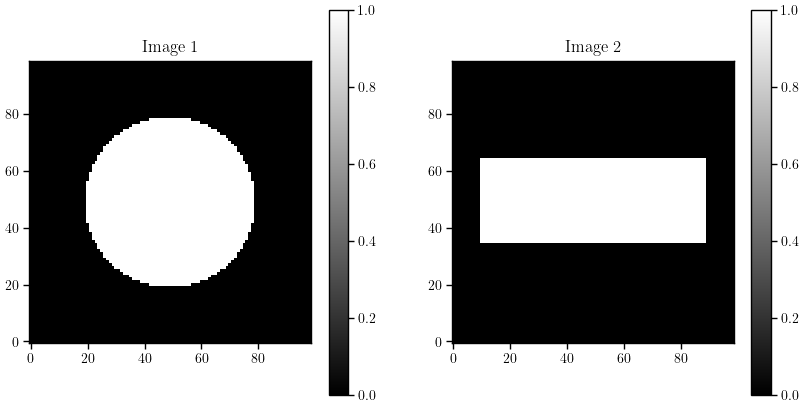

In [62]:
tmpdir = '/grad/bwedig/mejiro/hwo/notebooks'

# make some simple example images
imsz = 99
cenpix = imsz // 2
yy, xx = np.meshgrid(np.arange(imsz) - cenpix, np.arange(imsz) - cenpix)
im1 = ((xx ** 2 + yy ** 2) < 30 ** 2) * 1.0  # circle
im2 = im1 * 0
im2[35:65, 10:-10] = 1  # rectangle

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(im1, cmap='gray')
plt.title('Image 1')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(im2, cmap='gray')
plt.title('Image 2')
plt.colorbar()

plt.show()

In [34]:
from mejiro.instruments.roman import Roman
from mejiro.galaxy_galaxy import SampleGG, SampleSL2S, SampleBELLS
from mejiro.synthetic_image import SyntheticImage

strong_lens = SampleSL2S()
synthetic_image = SyntheticImage(strong_lens=strong_lens,
                                     instrument=Roman(),
                                     band='F087',
                                     fov_arcsec=10.7,
                                     instrument_params={'detector': 'SCA01'},
                                     # none provided
                                     kwargs_psf={},
                                     pieces=False,
                                     verbose=False)

im1 = synthetic_image.image

In [35]:
# make a PSF for these
psf = im1 * 0
psf[cenpix, cenpix] = 1
from scipy.ndimage import gaussian_filter
sigma = 1
psf = gaussian_filter(psf, sigma)

In [36]:
print(im1.shape, psf.shape)

(99, 99) (99, 99)


In [39]:
# set up the image catalog
from astropy.io import fits
filenames = [os.path.join(tmpdir, 'im1.fits'), os.path.join(tmpdir, 'im2.fits')]
fits.writeto(filenames[0], gaussian_filter(im1, sigma), overwrite=True)
fits.writeto(filenames[1], gaussian_filter(im2, sigma), overwrite=True)

# delete files in tmpdir that start with 'test_image_catalog'
for file in glob(os.path.join(tmpdir, 'test_image_catalog*')):
    os.remove(file)
base_rgc_filename = os.path.join(tmpdir, 'test_image_catalog')
catalog.make_image_catalog(filenames, psf, base_rgc_filename)

In [55]:
# make some metadata to describe an image for us to render
roman.n_pix = 500
coord = SkyCoord(270 * u.deg, 66 * u.deg)
meta = util.default_image_meta(coord=coord, filter_name='F087')
imwcs = wcs.get_wcs(meta, usecrds=False)

In [56]:
# make a table of sources for us to render
tab = table.Table()
cen = imwcs.toWorld(galsim.PositionD(roman.n_pix / 2, roman.n_pix / 2))
offsets = np.array([[-300, 300, -100, -200, 0, 0],
                    [0, 100, -200, -100, 0, -300]])
offsets = offsets * 0.1 / 60 / 60
tab['ra'] = util.skycoord(cen).ra.to(u.degree).value + offsets[0, :]
tab['dec'] = util.skycoord(cen).dec.to(u.degree).value + offsets[1, :]
tab['ident'] = np.arange(6) % 2  # alternate circles and rectangles
tab['rotate'] = np.arange(6) * 60
tab['shear_pa'] = (5 - np.arange(6)) * 60
tab['shear_ba'] = [0.5, 0.3, 0.9, 0.8, 1, 1]
tab['dilate'] = [0.5, 0.1, 0.9, 1.1, 2, 0.8]
tab['F087'] = [1e-7, 2e-7, 3e-7, 3e-7, 2e-7, 1e-7]
tab.meta['real_galaxy_catalog_filename'] = str(base_rgc_filename) + '.fits'

print(tab)

        ra                dec        ident rotate shear_pa shear_ba dilate  F087
------------------ ----------------- ----- ------ -------- -------- ------ -----
270.10780111380456  66.0768878098458     0      0      300      0.5    0.5 1e-07
 270.1244677804712 66.07966558762358     1     60      240      0.3    0.1 2e-07
 270.1133566693601 66.07133225429024     0    120      180      0.9    0.9 3e-07
270.11057889158235 66.07411003206802     1    180      120      0.8    1.1 3e-07
 270.1161344471379  66.0768878098458     0    240       60      1.0    2.0 2e-07
 270.1161344471379 66.06855447651246     1    300        0      1.0    0.8 1e-07


In [57]:
# render the image
res = image.simulate(meta, tab, usecrds=False, webbpsf=False)

2025-02-22 14:38:03 WARNING  --usecrds is not set.  romanisim will not use reference files from CRDS.  The WCS may be incorrect and up-to-date calibration information will not be used.


2025-02-22 14:38:03 WARNING  No RNG set, constructing a new default RNG from default seed.
2025-02-22 14:38:03 INFO     Simulating filter F087...
2025-02-22 14:38:07 INFO     Adding 6 sources to image...
2025-02-22 14:38:08 INFO     Rendered 6 sources...
2025-02-22 14:38:08 INFO     Apportioning electrons to resultants...
2025-02-22 14:38:15 INFO     Adding IPC...
2025-02-22 14:38:15 INFO     Adding read noise...
2025-02-22 14:38:15 INFO     Fitting ramps.
2025-02-22 14:38:15 INFO     Simulation complete.


In [58]:
# # did we get all the flux?
# totflux = np.sum(res[0].data - np.median(res[0].data))
# expectedflux = (romanisim.bandpass.get_abflux('F087', int(meta['instrument']['detector'][3:])) * np.sum(tab['F087'])
#                 / parameters.reference_data['gain'].value)
# assert np.abs(totflux / expectedflux - 1) < 0.1

# # are there sources where there should be?
# for r, d in zip(tab['ra'], tab['dec']):
#     x, y = imwcs.toImage(r, d, units=galsim.degrees)
#     x = int(x)
#     y = int(y)
#     assert res[0].data[y, x] > np.median(res[0].data) * 5
# log.info('DMS228: Successfully added rendered sources from image input; '
#             'sources are present and flux matches.')

In [59]:
# af = asdf.AsdfFile()
# af.tree = {'im1': im1,
#             'im2': im2,
#             'psf': psf,
#             'catalog': tab,
#             'output': res[0].data,
#             }
# af.write_to(os.path.join(tmpdir, 'dms228.asdf'))

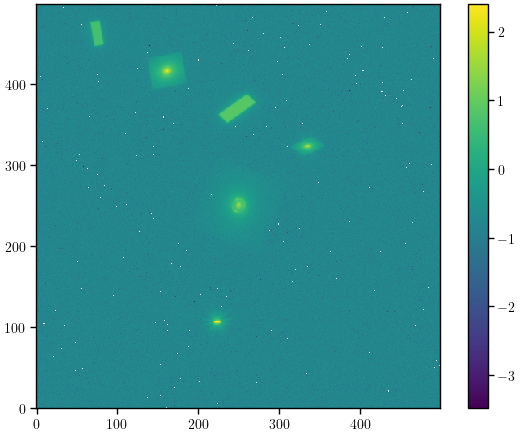

In [60]:
plt.imshow(np.log10(res[0].data))
plt.colorbar()
plt.show()

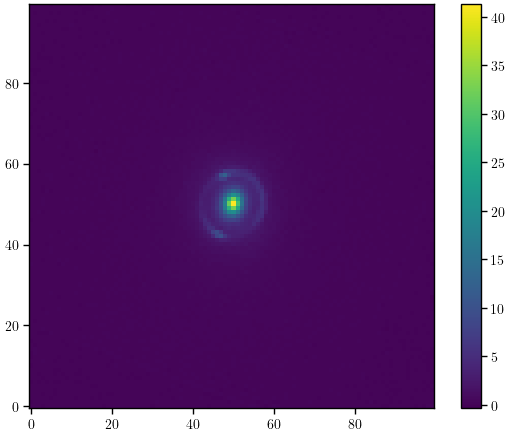

In [61]:
plt.imshow(res[0].data[200:300, 200:300])
plt.colorbar()
plt.show()